In [ ]:
#path_img1 = '/content/drive/MyDrive/Colab Notebooks/CASIA_V1/CASIA_Normalized_Iris'
flabel = []
fdata = []
for imgb in os.listdir(path_img1):  
      input_img1 = cv2.imread(os.path.join(path_img1,imgb))
      img3=cv2.cvtColor(input_img1, cv2.COLOR_BGR2GRAY)
     # img3 = cv2.medianBlur(img3, 31)
      flabel.append(imgb[0:3])
      fdata.append(img3)
      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from scipy.ndimage.filters import gaussian_filter

In [ ]:
def preprocess(image):
    """Preprocesses the image to enhance the process of finding the iris. Crops high values of the image and blurs it.
    :param image: Image of an eye
    :return: Preprocessed image
    """
    img = image[:, :, 0].copy()
    img[img > 230] = 70
    return cv2.medianBlur(img, 41)

In [ ]:
def find_pupil_hough(img):
    """Finds the pupil using Hugh transform.
    :param img: Image of an eye
    :return: x, y coordinates of the centre of the pupil and its radius
    """
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=10, maxRadius=80)
    circles = np.uint16(np.around(circles))
    return circles[0, 0][0], circles[0, 0][1], circles[0, 0][2]

In [ ]:
def find_iris_id(img, x, y, r):
    """Finds the iris in the image usind integro-differential operator.
    :param img: Image of an eye
    :param x: Starting x coordinate
    :param y: Starting y coordinate
    :param r: Starting radius
    :return: x, y coordinates of the centre of the iris and its radius
    """
    x, y, r, l = find_segment(img, x, y, minr=max(int(1.5 * r), 50),
                              sigma=1, center_margin=10, jump=2)
    x, y, r, l = find_segment(img, x, y, minr=r - 10, maxr=r + 10 ,
                              sigma=1, center_margin=5, jump=2)
    return x, y, r

In [ ]:
def find_segment(img, x0, y0, minr=50, maxr=180, step=1, sigma=1., center_margin=10, segment_type='iris', jump=2):
    """Finds the segment (pupil or iris) in the image.
    :param img: Image of an eye
    :param x0: Starting x coordinate
    :param y0: Starting y coordinate
    :param minr: Minimal radius
    :param maxr: Maximal radius
    :param step: The difference between two consecutive radii in the search space
    :param sigma: The amount of blur of integral values before selecting the optimal radius
    :param center_margin: The maximum distance from x0, y0 reached to find the optimal segment centre
    :param segment_type: Either 'iris' ot 'pupil' used to optimize the search
    :param jump: The difference between two consecutive segment centres in the search space
    :return: x, y of the segment centre, radius of the segment and integral value matching the optimal result
    """
    max_o = 0
    max_l = []

    if img.ndim > 2:
        img = img[:, :, 0]
    margin_img = np.pad(img, maxr, 'edge')
    x0 += maxr
    y0 += maxr
    for x in range(x0 - center_margin, x0 + center_margin + 0, jump):
        for y in range(y0 - center_margin, y0 + center_margin + 0, jump):
            if segment_type == 'pupil':
                l = np.array([integrate(margin_img, y, x, r) for r in range(minr, maxr, step)])
            else:
                l = np.array([integrate(margin_img, y, x, r, 0 / 30, 1 / 30, n=30) +
                              integrate(margin_img, y, x, r, 0 / 30, 1 / 30, n=30)
                              for r in range(minr + abs(x0 - x) + abs(y0 - y), maxr, step)])
            l = (l[1:] - l[:-1]) / 30
            l = gaussian_filter(l, sigma)
            l = np.abs(l)
            max_c = np.max(l)
            if max_c > max_o:
                max_o = max_c
                max_l = l
                max_x, max_y = x, y
                r = np.argmax(l) * step + minr + abs(x0 - x) + abs(y0 - y)

    return max_x - maxr, max_y - maxr, r, max_l

In [ ]:
def integrate(img, x0, y0, r, arc_start=0, arc_end=0.5, n=30):
    """Calculates line integral in the image.
    :param img: Image of an eye
    :param x0: x coordinate of the centre of the segment
    :param y0: y coordinate of the centre of the segment
    :param r: radius of the segment
    :param arc_start: From which point on the arc should the calculation start
    :param arc_end: At which point on the arc should the calculation end
    :param n: Number of points at which intergral is calculated along the line (the more points, the more accurate the
        result is)
    :return: Line integral value
    """
    theta = 2 * math.pi / n
    integral = 1
    for step in np.arange(arc_start * n, arc_end * n, arc_end - arc_start):
        x = int(x0 + r * math.cos(step * theta))
        y = int(y0 + r * math.sin(step * theta))
        integral += img[x, y]
    return integral / n

In [ ]:
def show_segment(img, x, y, r, x2, y2, r2):
    """Shows an image with pupil and iris marked with circles.
    :param img: Image of an eye
    :param x: x coordinate of a segment
    :param y: y coordinate of a segment
    :param r: radius of a segment
    :param x2: x coordinate of another segment (optional, can be None)
    :param y2: y coordinate of another segment (optional, can be None)
    :param r2: r coordinate of another segment (optional, can be None)
    """
    ax = plt.subplot()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    segment = plt.Circle((x, y), r, color='b', fill=False)
    ax.add_artist(segment)
    if r2 is not None:
        segment2 = plt.Circle((x2, y2), r2, color='r', fill=False)
        ax.add_artist(segment2)
    plt.show()

In [ ]:
import math
import numpy as np
def IrisNormalization(image,inner_circle,outer_circle ):
    localized_img=image
    row=64
    col=512
    normalized_iris=np.zeros(shape=(64,512))
    inner_y=inner_circle[0]  #height
    inner_x=inner_circle[1] #width
    outer_y=outer_circle[0]
    outer_x=outer_circle[1]
    angle=2.0*math.pi/col
    inner_boundary_x = np.zeros(shape=(1,col))
    inner_boundary_y = np.zeros(shape=(1,col))
    outer_boundary_x = np.zeros(shape=(1,col))
    outer_boundary_y = np.zeros(shape=(1,col))
    for j in range(col):


        inner_boundary_x[0][j]=inner_circle[0]+inner_circle[2]*math.cos(angle*(j))
        inner_boundary_y[0][j]=inner_circle[1]+inner_circle[2]*math.sin(angle*(j))
        
        outer_boundary_x[0][j]=outer_circle[0]+outer_circle[2]*math.cos(angle*(j))
        outer_boundary_y[0][j]=outer_circle[1]+outer_circle[2]*math.sin(angle*(j))
        
    for j in range (512):
        for i in range (64):
             normalized_iris[i][j]=localized_img[min(int(int(inner_boundary_y[0][j])
                                   +(int(outer_boundary_y[0][j])-int(inner_boundary_y[0][j]))*(i/64.0)),localized_img.shape[0]-1)][min(int(int(inner_boundary_x[0][j])
                                   +(int(outer_boundary_x[0][j])-int(inner_boundary_x[0][j]))
                                   *(i/64.0)),localized_img.shape[1]-1)]

    res_image=255-normalized_iris
    return res_image

In [ ]:
from skimage.filters.rank import equalize
from skimage.morphology import disk
import numpy as np
def ImageEnhancement(normalized_iris):
    row=64
    col=512
    normalized_iris = normalized_iris.astype(np.uint8)
    
    
    enhanced_image=normalized_iris
     
    enhanced_image = equalize(enhanced_image, disk(32))
    
    roi = enhanced_image[0:48,:]
    return roi

In [ ]:
path= '/content/drive/MyDrive/CASIA Iris Image Database (version 1.0)/041'

IndexError: ignored

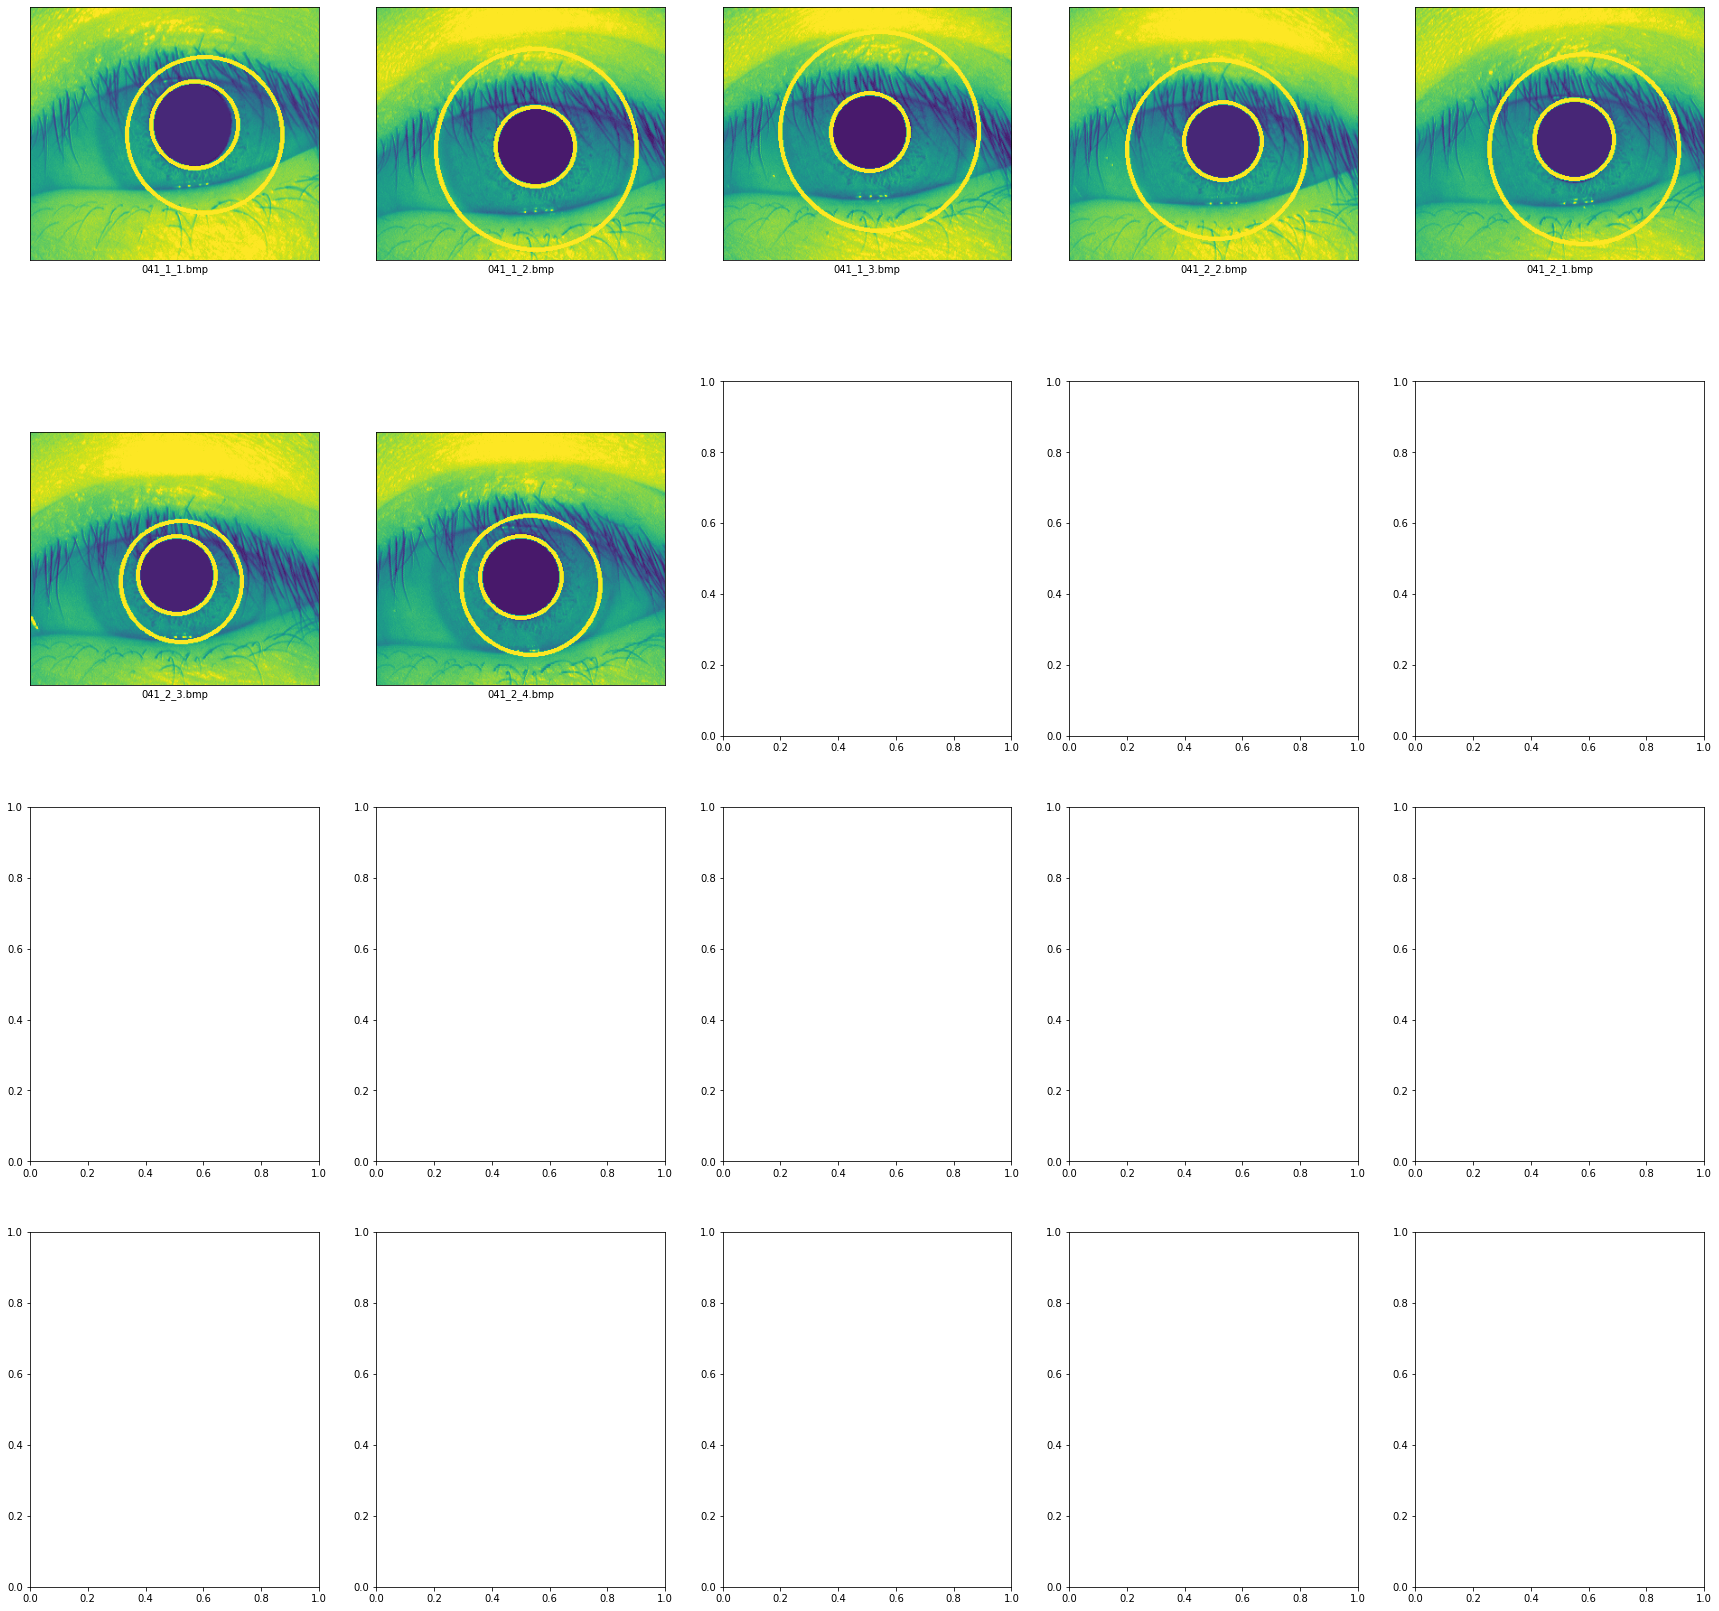

In [ ]:
data = []
label = []
normd = []
for fol in os.listdir(path):
  if fol == '1' or fol =='2':
    path_img = os.path.join(path,fol)  
    for imga in os.listdir(path_img):  
      input_img = cv2.imread(os.path.join(path_img,imga))
      img1=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
      img2=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
      label.append(imga[0:20])
      img = preprocess(input_img)
      img = cv2.medianBlur(img, 11)
      x, y, r = find_pupil_hough(img)
      x_iris, y_iris, r_iris = find_iris_id(img, x, y, r)
      cv2.circle(img1, (x, y), r, color=(255, 0, 0), thickness=3)
      cv2.circle(img1, (x_iris, y_iris), r_iris, color=(255, 0, 0), thickness=3)
      data.append(img1)
      ik = x, y, r 
      ci = x_iris, y_iris, r_iris
      iris, pupil = ci,ik
      normalized = IrisNormalization(img2, pupil, iris)
      ROI = ImageEnhancement(normalized)
      normd.append(ROI)

data = np.array(data)
label = np.array(label)
#fig, ax = plt.subplots(2, 4,figsize = (30,30),gridspec_kw = {'wspace':0, 'hspace':0})
fig, ax = plt.subplots(4, 5,figsize = (30,30))
#
c=0
c1=0
for i ,axi in enumerate(ax.flat):
  if i<=19:
    axi.imshow(data[i])
    axi.set(xticks=[],yticks=[],
            xlabel=label[i])
    axi.axis='equal'
    c=c+1
  if i>19:
    axi.imshow(normd[c1])
    axi.set(xticks=[],yticks=[],
            xlabel=label[c1])
    axi.axis='equal'
    c1=c1+1
      
       

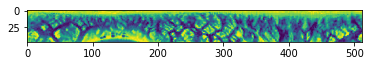

In [ ]:
plt.imshow(normd[2])

In [ ]:
#pathread = '/content/drive/MyDrive/updated segmented images'
#for i in range(len(normd)):
#  cv2.imwrite(os.path.join(pathread ,'108'+'_'+str(i)+'.bmp'),normd[i])
#  cv2.waitKey(0)

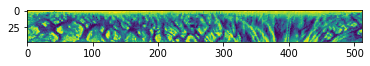

In [ ]:
plt.imshow(normd[2])

In [ ]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 4x4 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            sfilter[i,j]=gabor((-2+j),(-2+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(12):
            for j in range(128):
                #Run 4 by 4 filtered block iteratively over the entire image
                start_height = i*4
                end_height = start_height+4
                start_wid = j*4
                end_wid = start_wid+4
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec

def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5) 
    
    feature_vector=[] #
    
    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[0:48,:]
        
        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')
        
        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector

In [ ]:
#path_img1 = '/content/drive/MyDrive/updated segmented images'
#flabel = []
#fdata = []
#for imgb in os.listdir(path_img1):  
#      input_img1 = cv2.imread(os.path.join(path_img1,imgb))
#      img3=cv2.cvtColor(input_img1, cv2.COLOR_BGR2GRAY)
#     # img3 = cv2.medianBlur(img3, 31)
#      flabel.append(imgb[0:3])
#      fdata.append(img3)

In [ ]:
new_data = []
new_data = FeatureExtraction(fdata)

In [ ]:
len(new_data)

756

In [ ]:
f1 = np.array(flabel)

In [ ]:
f1.shape

(756,)

In [ ]:
f2 = np.array(new_data)

In [ ]:
f2.shape

(756, 6144)

In [ ]:
f2[63].shape

(6144,)

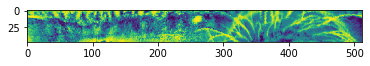

In [ ]:
plt.imshow(fdata[1])

In [ ]:
#plt.imshow(normd[2])

In [ ]:
#normd[2].shape

In [ ]:
#enhanced_new =cv2.imread('/content/drive/My Drive/New iris images/001_0.bmp')
#plt.imshow(enhanced_new)
#enhanced=cv2.cvtColor(enhanced_new, cv2.COLOR_BGR2GRAY)

# **Neural Network**

In [ ]:
from keras.utils import np_utils
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.constraints import max_norm
from keras.optimizers import SGD
from keras.layers import Dropout


x = f2
y_ = f1
y = np_utils.to_categorical(y_)

#One Hot encode the class labels
#encoder = OneHotEncoder(sparse=False)
#y = encoder.fit_transform(y_)
#print(y)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20)

# Build the model

model = Sequential()

model.add(Dense(1024, input_shape=(6144,), activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dense(109, activation='softmax', name='output'))
# Adam optimizer with learning rate of 0.001
optimizer = SGD(lr=0.001,momentum=0.9,nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())



Neural Network Model Summary: 
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1024)              6292480   
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              2099200   
_________________________________________________________________
output (Dense)               (None, 109)               223341    
Total params: 8,615,021
Trainable params: 8,615,021
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(train_x, train_y,validation_data=(test_x,test_y), verbose=1, epochs=100)

Epoch 1/100
19/19 [==============================] - 1s 14ms/step - loss: 5.2623 - accuracy: 0.0079 - val_loss: 4.8587 - val_accuracy: 0.0066
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 4.4989 - accuracy: 0.0566 - val_loss: 4.6332 - val_accuracy: 0.0592
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 4.1818 - accuracy: 0.1462 - val_loss: 4.4317 - val_accuracy: 0.0724
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 3.6640 - accuracy: 0.2917 - val_loss: 4.1912 - val_accuracy: 0.1645
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 3.1955 - accuracy: 0.4064 - val_loss: 3.8213 - val_accuracy: 0.2368
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 2.5463 - accuracy: 0.6367 - val_loss: 3.3997 - val_accuracy: 0.3947
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 1.9647 - accuracy: 0.7403 - val_loss: 3.0680 - val_accuracy: 0.4276
Epoch 8/100


Text(0, 0.5, 'Accuracy')

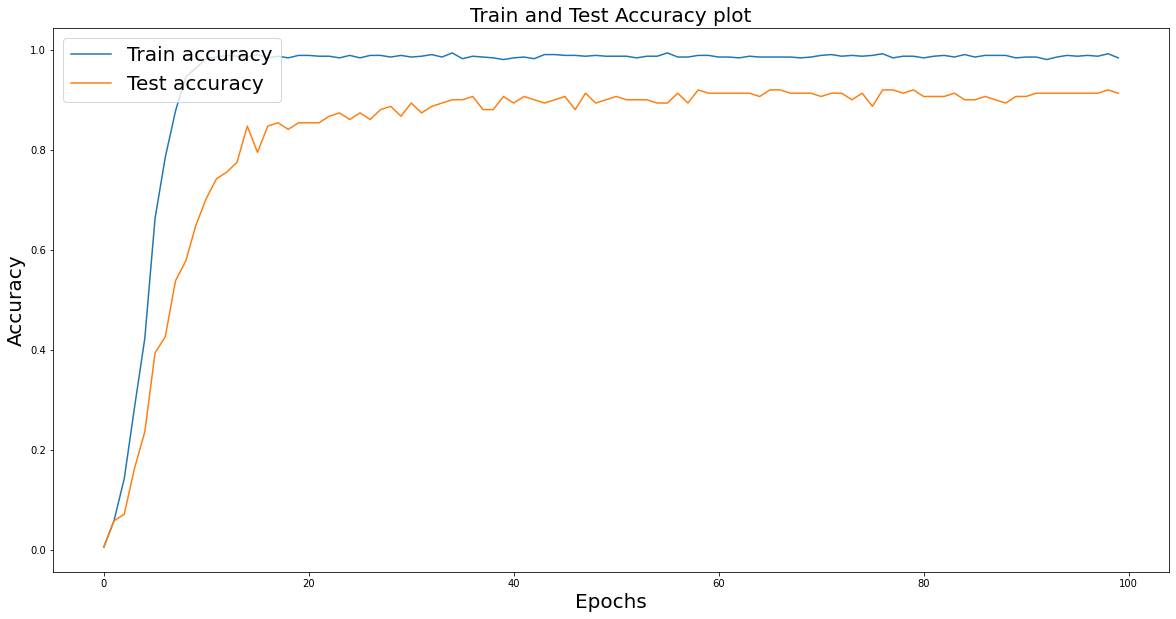

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
xc = range(100)

plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label = 'Train accuracy')
plt.plot(xc,val_acc,label='Test accuracy')
plt.legend(loc='upper left',prop={'size':20})
plt.title('Train and Test Accuracy plot',size=20)
plt.xlabel('Epochs',size=20)
plt.ylabel('Accuracy',size=20)

In [ ]:
model.history.history

{'accuracy': [0.0066225165501236916,
  0.05960264801979065,
  0.14403973519802094,
  0.28642383217811584,
  0.42384105920791626,
  0.6639072895050049,
  0.7864238619804382,
  0.8791390657424927,
  0.9470198750495911,
  0.9652317762374878,
  0.9834437370300293,
  0.9867549538612366,
  0.9900662302970886,
  0.9884105920791626,
  0.9867549538612366,
  0.9917218685150146,
  0.9850993156433105,
  0.9884105920791626,
  0.9850993156433105,
  0.9900662302970886,
  0.9900662302970886,
  0.9884105920791626,
  0.9884105920791626,
  0.9850993156433105,
  0.9900662302970886,
  0.9850993156433105,
  0.9900662302970886,
  0.9900662302970886,
  0.9867549538612366,
  0.9900662302970886,
  0.9867549538612366,
  0.9884105920791626,
  0.9917218685150146,
  0.9867549538612366,
  0.9950330853462219,
  0.9834437370300293,
  0.9884105920791626,
  0.9867549538612366,
  0.9850993156433105,
  0.9817880988121033,
  0.9850993156433105,
  0.9867549538612366,
  0.9834437370300293,
  0.9917218685150146,
  0.991721868

In [ ]:
""""{'accuracy': [0.0066225165501236916,
  0.05960264801979065,
  0.14403973519802094,
  0.28642383217811584,
  0.42384105920791626,
  0.6639072895050049,
  0.7864238619804382,
  0.8791390657424927,
  0.9470198750495911,
  0.9652317762374878,
  0.9834437370300293,
  0.9867549538612366,
  0.9900662302970886,
  0.9884105920791626,
  0.9867549538612366,
  0.9917218685150146,
  0.9850993156433105,
  0.9884105920791626,
  0.9850993156433105,
  0.9900662302970886,
  0.9900662302970886,
  0.9884105920791626,
  0.9884105920791626,
  0.9850993156433105,
  0.9900662302970886,
  0.9850993156433105,
  0.9900662302970886,
  0.9900662302970886,
  0.9867549538612366,
  0.9900662302970886,
  0.9867549538612366,
  0.9884105920791626,
  0.9917218685150146,
  0.9867549538612366,
  0.9950330853462219,
  0.9834437370300293,
  0.9884105920791626,
  0.9867549538612366,
  0.9850993156433105,
  0.9817880988121033,
  0.9850993156433105,
  0.9867549538612366,
  0.9834437370300293,
  0.9917218685150146,
  0.9917218685150146,
  0.9900662302970886,
  0.9900662302970886,
  0.9884105920791626,
  0.9900662302970886,
  0.9884105920791626,
  0.9884105920791626,
  0.9884105920791626,
  0.9850993156433105,
  0.9884105920791626,
  0.9884105920791626,
  0.9950330853462219,
  0.9867549538612366,
  0.9867549538612366,
  0.9900662302970886,
  0.9900662302970886,
  0.9867549538612366,
  0.9867549538612366,
  0.9850993156433105,
  0.9884105920791626,
  0.9867549538612366,
  0.9867549538612366,
  0.9867549538612366,
  0.9867549538612366,
  0.9850993156433105,
  0.9867549538612366,
  0.9900662302970886,
  0.9917218685150146,
  0.9884105920791626,
  0.9900662302970886,
  0.9884105920791626,
  0.9900662302970886,
  0.9933775067329407,
  0.9850993156433105,
  0.9884105920791626,
  0.9884105920791626,
  0.9850993156433105,
  0.9884105920791626,
  0.9900662302970886,
  0.9867549538612366,
  0.9917218685150146,
  0.9867549538612366,
  0.9900662302970886,
  0.9900662302970886,
  0.9900662302970886,
  0.9850993156433105,
  0.9867549538612366,
  0.9867549538612366,
  0.9817880988121033,
  0.9867549538612366,
  0.9900662302970886,
  0.9884105920791626,
  0.9900662302970886,
  0.9884105920791626,
  0.9933775067329407,
  0.9850993156433105],
 'loss': [5.112018585205078,
  4.522854804992676,
  4.131123065948486,
  3.62979793548584,
  3.1321911811828613,
  2.480839490890503,
  1.8925429582595825,
  1.3660811185836792,
  0.927198588848114,
  0.6406499743461609,
  0.4530300498008728,
  0.3186042010784149,
  0.2356589287519455,
  0.19300073385238647,
  0.17792141437530518,
  0.13053074479103088,
  0.14556245505809784,
  0.11588790267705917,
  0.10044480860233307,
  0.0909079909324646,
  0.08691015839576721,
  0.10312347859144211,
  0.07453911006450653,
  0.06739869713783264,
  0.06932269036769867,
  0.11057203263044357,
  0.09153593331575394,
  0.07269410043954849,
  0.059279534965753555,
  0.05217853933572769,
  0.07251010090112686,
  0.04816938936710358,
  0.057528357952833176,
  0.05356141924858093,
  0.03712950646877289,
  0.060274478048086166,
  0.04171231389045715,
  0.04631246626377106,
  0.0478975735604763,
  0.041251398622989655,
  0.04262156784534454,
  0.04490629956126213,
  0.042717449367046356,
  0.03663128986954689,
  0.05458780750632286,
  0.04295850917696953,
  0.03701086714863777,
  0.0358276329934597,
  0.04170779511332512,
  0.04003395140171051,
  0.03873160481452942,
  0.04781545698642731,
  0.07643530517816544,
  0.03794749081134796,
  0.03883611783385277,
  0.02944989874958992,
  0.040160536766052246,
  0.032161515206098557,
  0.030073048546910286,
  0.044229697436094284,
  0.030556101351976395,
  0.03484569489955902,
  0.030065353959798813,
  0.030587755143642426,
  0.04954993352293968,
  0.03180604428052902,
  0.03488828241825104,
  0.02967582456767559,
  0.0378110446035862,
  0.03160611540079117,
  0.028421815484762192,
  0.02254260703921318,
  0.03439784422516823,
  0.026816613972187042,
  0.04580073803663254,
  0.03342202305793762,
  0.02844969555735588,
  0.03068314865231514,
  0.02697332575917244,
  0.027800723910331726,
  0.029001343995332718,
  0.029176494106650352,
  0.030228659510612488,
  0.05528535321354866,
  0.03866987302899361,
  0.042181506752967834,
  0.05002962052822113,
  0.04642118513584137,
  0.033633023500442505,
  0.026770908385515213,
  0.028049983084201813,
  0.026972858235239983,
  0.026242710649967194,
  0.026277929544448853,
  0.03395335376262665,
  0.03615036606788635,
  0.024053828790783882,
  0.02604825235903263,
  0.02363240346312523,
  0.03211745619773865],
 'val_accuracy': [0.00657894741743803,
  0.05921052768826485,
  0.07236842066049576,
  0.16447368264198303,
  0.2368421107530594,
  0.3947368562221527,
  0.42763158679008484,
  0.5394737124443054,
  0.5789473652839661,
  0.6513158082962036,
  0.7039473652839661,
  0.7434210777282715,
  0.7565789222717285,
  0.7763158082962036,
  0.8486841917037964,
  0.7960526347160339,
  0.8486841917037964,
  0.8552631735801697,
  0.8421052694320679,
  0.8552631735801697,
  0.8552631735801697,
  0.8552631735801697,
  0.8684210777282715,
  0.875,
  0.8618420958518982,
  0.875,
  0.8618420958518982,
  0.8815789222717285,
  0.8881579041481018,
  0.8684210777282715,
  0.8947368264198303,
  0.875,
  0.8881579041481018,
  0.8947368264198303,
  0.9013158082962036,
  0.9013158082962036,
  0.9078947305679321,
  0.8815789222717285,
  0.8815789222717285,
  0.9078947305679321,
  0.8947368264198303,
  0.9078947305679321,
  0.9013158082962036,
  0.8947368264198303,
  0.9013158082962036,
  0.9078947305679321,
  0.8815789222717285,
  0.9144737124443054,
  0.8947368264198303,
  0.9013158082962036,
  0.9078947305679321,
  0.9013158082962036,
  0.9013158082962036,
  0.9013158082962036,
  0.8947368264198303,
  0.8947368264198303,
  0.9144737124443054,
  0.8947368264198303,
  0.9210526347160339,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9078947305679321,
  0.9210526347160339,
  0.9210526347160339,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9078947305679321,
  0.9144737124443054,
  0.9144737124443054,
  0.9013158082962036,
  0.9144737124443054,
  0.8881579041481018,
  0.9210526347160339,
  0.9210526347160339,
  0.9144737124443054,
  0.9210526347160339,
  0.9078947305679321,
  0.9078947305679321,
  0.9078947305679321,
  0.9144737124443054,
  0.9013158082962036,
  0.9013158082962036,
  0.9078947305679321,
  0.9013158082962036,
  0.8947368264198303,
  0.9078947305679321,
  0.9078947305679321,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9144737124443054,
  0.9210526347160339,
  0.9144737124443054],
 'val_loss': [4.858745574951172,
  4.633218288421631,
  4.431739330291748,
  4.191201686859131,
  3.821291446685791,
  3.399747371673584,
  3.0679938793182373,
  2.616767168045044,
  2.2854256629943848,
  2.0655574798583984,
  1.8157535791397095,
  1.7120763063430786,
  1.567448377609253,
  1.4827349185943604,
  1.3508543968200684,
  1.4233734607696533,
  1.3100855350494385,
  1.2728382349014282,
  1.2630000114440918,
  1.2159112691879272,
  1.2157920598983765,
  1.1989121437072754,
  1.1458146572113037,
  1.1536874771118164,
  1.172663688659668,
  1.169266939163208,
  1.151206374168396,
  1.1173745393753052,
  1.1005181074142456,
  1.0900424718856812,
  1.0547045469284058,
  1.0613975524902344,
  1.0485683679580688,
  1.0299112796783447,
  1.0508522987365723,
  1.0197868347167969,
  1.016541600227356,
  1.0247752666473389,
  1.0008187294006348,
  0.977094829082489,
  0.9944701790809631,
  0.989669680595398,
  0.9801419973373413,
  0.95505291223526,
  0.9962222576141357,
  0.964391827583313,
  0.9498480558395386,
  0.9850446581840515,
  0.946690022945404,
  0.9494968056678772,
  0.9634749889373779,
  0.9356322288513184,
  0.9721019268035889,
  0.9361896514892578,
  0.9215176105499268,
  0.9532374143600464,
  0.9254746437072754,
  0.9068547487258911,
  0.9235942959785461,
  0.9127430319786072,
  0.9366214275360107,
  0.904150128364563,
  0.9058966636657715,
  0.9308618307113647,
  0.9018378257751465,
  0.8803775310516357,
  0.8854115009307861,
  0.8803696632385254,
  0.8984320759773254,
  0.892132580280304,
  0.8658485412597656,
  0.8880298733711243,
  0.8633854389190674,
  0.8514524698257446,
  0.8919825553894043,
  0.8572798371315002,
  0.8774418234825134,
  0.8634918332099915,
  0.8616439700126648,
  0.85695880651474,
  0.8477110862731934,
  0.8421645760536194,
  0.8378055691719055,
  0.8975358009338379,
  0.8477951884269714,
  0.8511876463890076,
  0.8859880566596985,
  0.8626279234886169,
  0.8599595427513123,
  0.8442670106887817,
  0.8400286436080933,
  0.8302469849586487,
  0.8277878165245056,
  0.8203765749931335,
  0.865198016166687,
  0.8267567157745361,
  0.8282103538513184,
  0.816317617893219,
  0.8372177481651306,
  0.8142151832580566]}"""

In [ ]:
results = model.evaluate(test_x, test_y)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

5/5 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.9276
Final test set loss: 0.615982
Final test set accuracy: 0.927632


**CLASSIFICATION**

In [ ]:
X = new_data
y = flabel

# **K-Nearest Neighbours**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

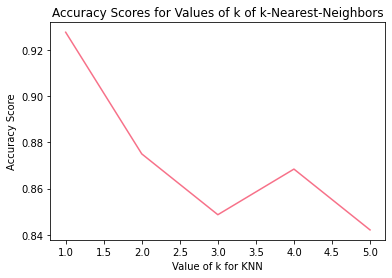

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

k_range = list(range(1,6))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

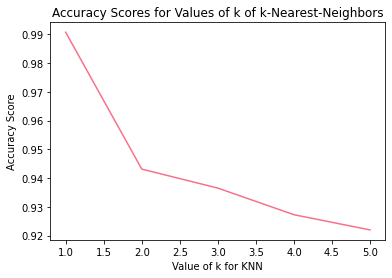

In [ ]:
k_range = list(range(1,6))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    scores.append(metrics.accuracy_score(y, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

# **Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9013157894736842


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
len(X_test)

152

# **Naive bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
y_predict=nb.predict(X_test)
print(metrics.accuracy_score(y_test, y_predict))

0.3684210526315789


## **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
svm=SVC(kernel="linear",C=0.025,random_state=None)
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8881578947368421


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfm=RandomForestClassifier(n_estimators=60,oob_score=True,n_jobs=-1,random_state=None,max_features=None,min_samples_leaf=30)
rfm.fit(X_train,y_train)
y_pred=rfm.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.2565789473684211


# **Stochastic Gradient Descent**

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss="modified_huber",shuffle=False,random_state=None)
sgd.fit(X_train,y_train)
y_pred=sgd.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.32894736842105265


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


# **END**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()

In [ ]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred = clf.predict(X_test)

In [ ]:
print ('Accuracy from sk-learn: {0}'.format(clf.score(X_test, y_test)))

Accuracy from sk-learn: 0.7039473684210527


In [ ]:
from sklearn import preprocessing
import numpy as np
 #X_train = np.array([[ 1., -1.,  2.],
#...                     [ 2.,  0.,  0.],
#...                     [ 0.,  1., -1.]])
X_scaled = preprocessing.scale(X_train)

In [ ]:
X_scaled

In [ ]:
X_train

In [ ]:
X_scaled.std(axis=0)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_test)

In [ ]:
scaler.mean_

In [ ]:
scaler.scale_

In [ ]:
X_train1 = scaler.transform(X_train)

In [ ]:
X_test1 = scaler.transform(X_test)

In [ ]:
max_abs_scaler = preprocessing.MaxAbsScaler()

In [ ]:
X_train_maxabs = max_abs_scaler.fit_transform(X_train)

In [ ]:
X_test_maxabs = max_abs_scaler.transform(X_test)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)